# Cuaderno de entrenamiento de precio de la vivienda

## 1. Business Case Discovery y Entendimiento del Problema
- Objetivo del negocio:

    - Contexto: La firma de inversión inmobiliaria quiere predecir con alta precisión el precio de las viviendas para maximizar rentabilidad y minimizar riesgos.
    - Requisitos: El margen de error debe ser inferior al 10%, con métricas como RMSE < 5% del precio promedio y R² > 0.85.

- Importancia:

    - Entender el impacto de una mala estimación (pérdidas millonarias) y los requerimientos de interpretabilidad, escalabilidad y despliegue en entornos cloud.
    
- Acciones:

    - Revisar el dataset (ubicado en Kaggle) para conocer las variables y la naturaleza de los datos.
    - Identificar stakeholders (inversores, equipo legal y técnico) y sus necesidades.

## 2 Data Processing

### 2.1. Carga y Exploración Inicial

- Acciones:
    - Descargar el [dataset](https://www.kaggle.com/datasets/yasserh/housing-prices-dataset) de Kaggle.
    - Cargar el dataset en un DataFrame de pandas.
    - Visualizar las primeras filas para familiarizarte con la estructura de los datos.
    - Generar histogramas y diagramas de caja para entender la distribución de cada variable.

- Objetivos:

    - Identificar valores atípicos (outliers).
    - Detectar posibles valores nulos.
    - Conocer la distribución de variables numéricas (por ejemplo, area, bedrooms, etc.) y variables categóricas (por ejemplo, mainroad, furnishingstatus).

In [ ]:
! pip install pandas matplotlib seaborn

Primeras 5 filas del dataset:
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  

Resumen estadístico:
              price          area    bedrooms  

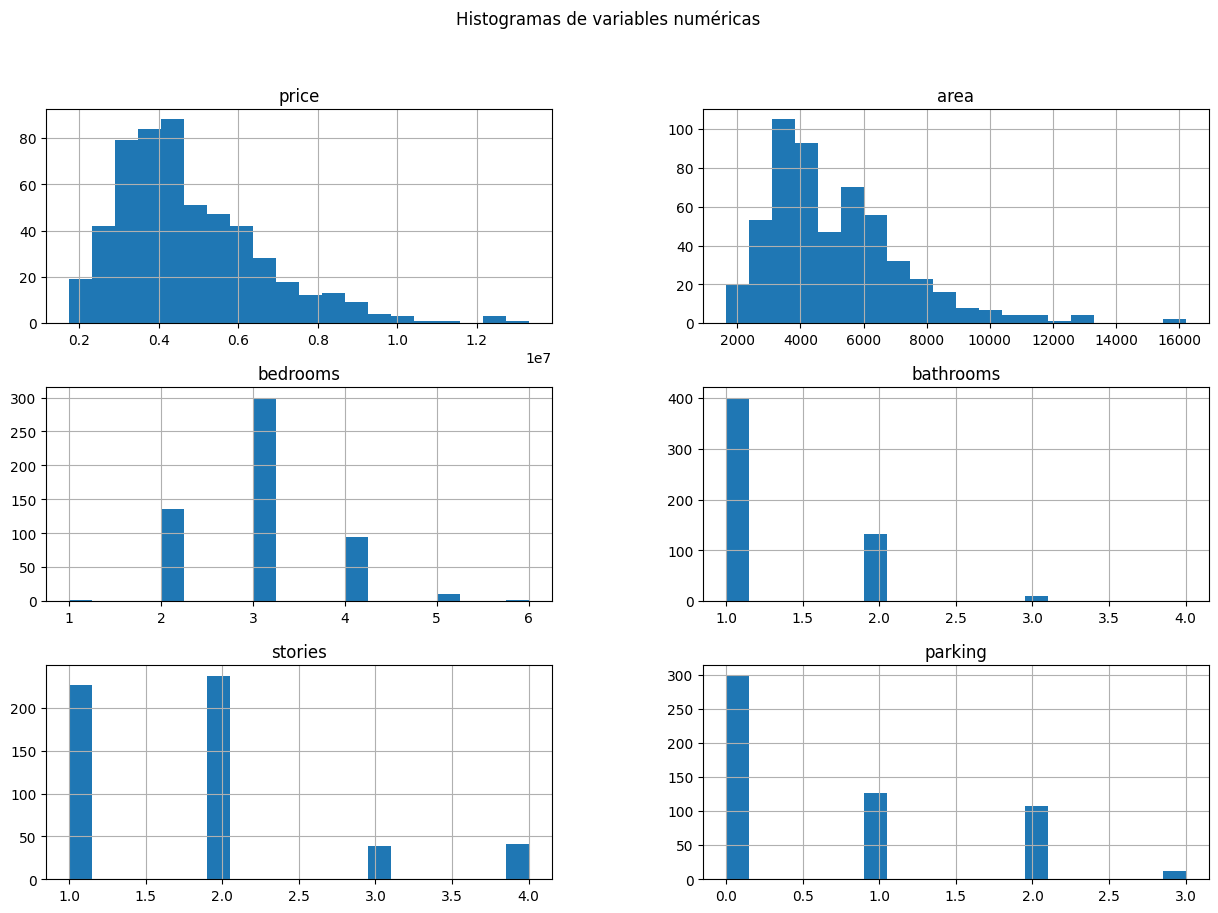

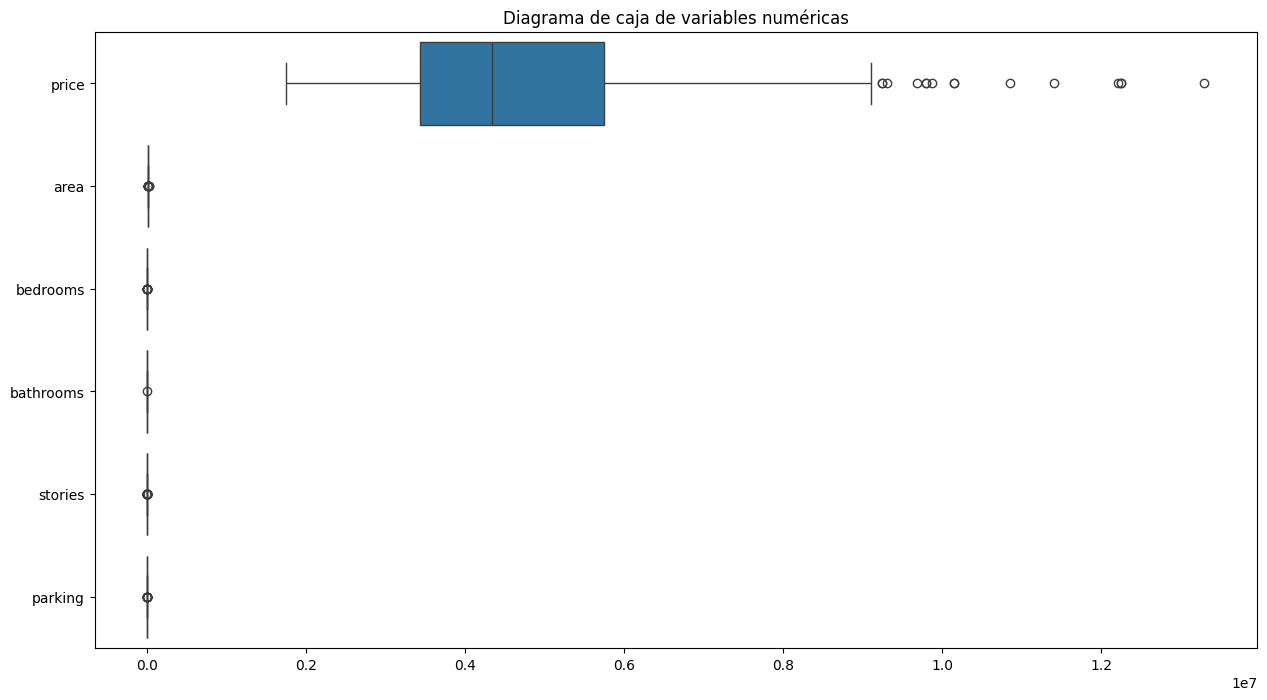

In [2]:
# Importamos las librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración básica de gráficos en línea (si estás usando Jupyter Notebook)
%matplotlib inline

# 1. Cargar el dataset (asegúrate de tener el archivo 'housing.csv' en tu directorio)
df = pd.read_csv('housing.csv')

# 2. Visualizar las primeras filas del dataset
print("Primeras 5 filas del dataset:")
print(df.head())

# 3. Resumen estadístico de las variables numéricas
print("\nResumen estadístico:")
print(df.describe())

# 4. Verificar si hay valores nulos
print("\nInformación del dataset:")
print(df.info())

# 5. Histograma para variables numéricas
df.hist(bins=20, figsize=(15,10))
plt.suptitle("Histogramas de variables numéricas")
plt.show()

# 6. Diagrama de caja para detectar outliers en variables numéricas
plt.figure(figsize=(15,8))
sns.boxplot(data=df, orient='h')
plt.title("Diagrama de caja de variables numéricas")
plt.show()


#### 2.1.1 Transformaciones a los datos

La decisión de mantener los datos tal cual o aplicar una transformación logarítmica depende principalmente de dos factores:

1. Grado de sesgo en la distribución (skewness).
2. Impacto de ese sesgo en el rendimiento e interpretabilidad del modelo.

En un escenario inmobiliario, es habitual encontrarse con propiedades de lujo o muy grandes que elevan mucho el precio y el área. Estos no siempre son “errores” sino parte real del mercado. Sin embargo, cuando la distribución está fuertemente sesgada, el modelo puede tener dificultades para ajustar correctamente los datos. Ahí es donde la transformación logarítmica puede ayudar.

##### Cómo decidir en la práctica?

1.Mira la magnitud del sesgo:

- Un método sencillo es calcular el coeficiente de asimetría (skewness).

- Si el valor de skewness es muy alto (por ejemplo, > 1 o 2, dependiendo de la escala), a menudo se considera que la variable está muy sesgada.


In [ ]:
import numpy as np

# Supongamos que tu DataFrame se llama df
# Seleccionar solo las columnas numéricas
numeric_cols = df.select_dtypes(include=[np.number])

# Calcular el skewness de cada columna numérica
skew_values = numeric_cols.skew()

print("Coeficiente de asimetría (skewness) de cada variable numérica:")
print(skew_values)

# Ejemplo: ver específicamente la asimetría de 'price'
print("\nAsimetría de la variable 'price':", df['price'].skew())


Coeficiente de asimetría (skewness) de cada variable numérica:
price        1.212239
area         1.321188
bedrooms     0.495684
bathrooms    1.589264
stories      1.082088
parking      0.842062
dtype: float64

Asimetría de la variable 'price': 1.2122388370279802



2.Prueba con y sin transformación:

- Entrena un modelo (aunque sea sencillo, por ejemplo, una regresión lineal) con los datos originales.

- Luego entrena el mismo modelo con la variable objetivo transformada (por ejemplo, price_log = np.log(price)).
- Compara métricas como MAE, RMSE y R² en ambos casos.

3.Analiza el impacto en la interpretación:

- Con price transformado a log(price), la salida del modelo es el logaritmo del precio. - Para obtener el precio real, tendrías que hacer np.exp(predicted_value).

- En un modelo de regresión lineal, los coeficientes con log(price) pueden interpretarse como variaciones porcentuales (lo cual es útil en economía). En una red neuronal, la interpretación directa de los pesos no es tan simple, pero sí se mantiene la ventaja de que las distribuciones estén más “normalizadas”.

Conclusión, aplicaremos las transformaciones con el objetivo de mejorar el rendimiento del moodelo. 

### 2.2 Análisis de Correlación

- Acciones:
    - Calcular y visualizar la matriz de correlación (por ejemplo, usando seaborn.heatmap).
    - Identificar qué variables tienen mayor correlación con la variable objetivo (price).
- Objetivos:
    - Detectar multicolinealidad (por ejemplo, si area, bedrooms y bathrooms están fuertemente correlacionados).
    - Evaluar la posibilidad de eliminar o combinar variables redundantes.


Antes de decidir sobre transformaciones o eliminación de outliers, te propongo calcular la matriz de correlación para ver cómo se relacionan las variables entre sí y con el price. Esto nos ayudará a:

- Identificar qué variables tienen mayor influencia en el precio.
- Detectar posibles casos de multicolinealidad (por ejemplo, area y bedrooms podrían estar muy correlacionados).

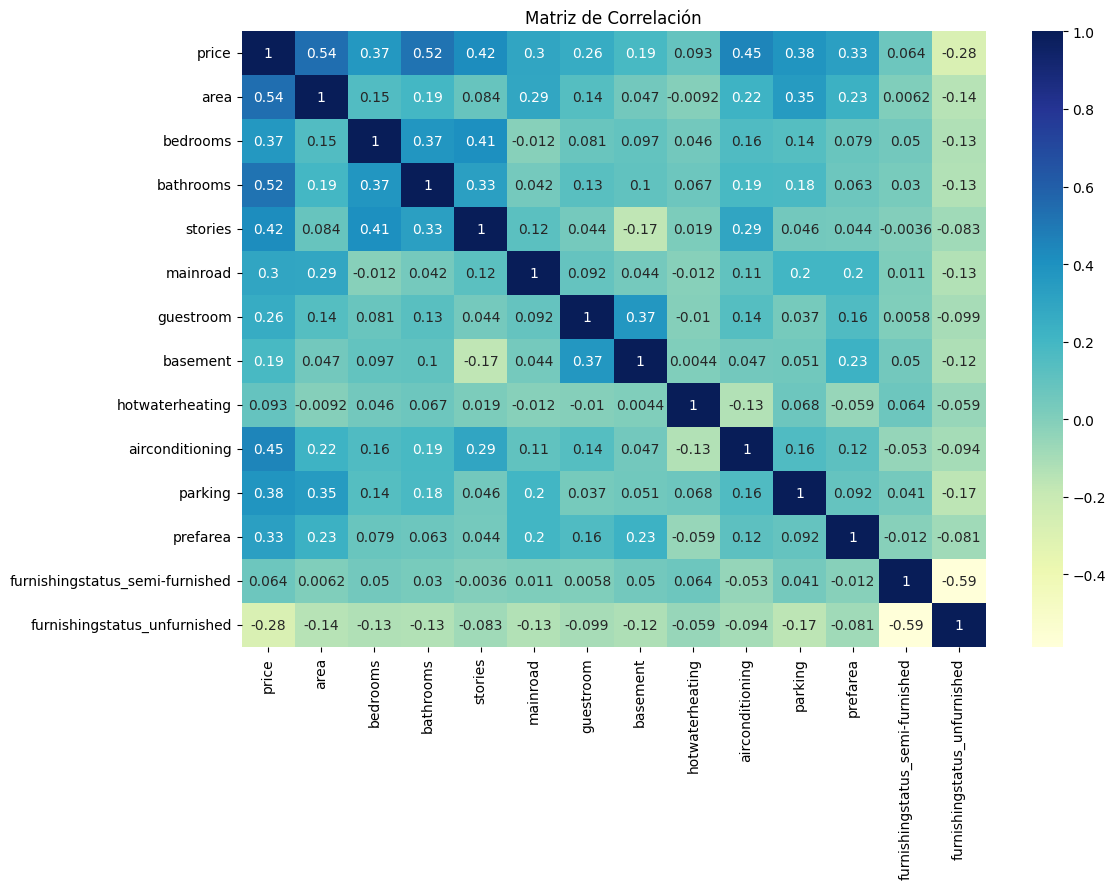


Correlaciones con price:
price                              1.000000
area                               0.535997
bathrooms                          0.517545
airconditioning                    0.452954
stories                            0.420712
parking                            0.384394
bedrooms                           0.366494
prefarea                           0.329777
mainroad                           0.296898
guestroom                          0.255517
basement                           0.187057
hotwaterheating                    0.093073
furnishingstatus_semi-furnished    0.063656
furnishingstatus_unfurnished      -0.280587
Name: price, dtype: float64


In [ ]:
# Usando seaborn para visualizar la matriz de correlación
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir las variables categóricas binarias en 0/1 para que aparezcan en la matriz de correlación
df_encoded = df.copy()

binary_cols = ['mainroad', 'guestroom', 'basement', 
               'hotwaterheating', 'airconditioning', 'prefarea']
for col in binary_cols:
    df_encoded[col] = df_encoded[col].map({'yes': 1, 'no': 0})

# 'furnishingstatus' tiene 3 categorías: realizaremos un one-hot encoding rápido para la correlación
df_encoded = pd.get_dummies(df_encoded, columns=['furnishingstatus'], drop_first=True)

# Calcular la matriz de correlación sólo de las variables numéricas
corr_matrix = df_encoded.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu')
plt.title("Matriz de Correlación")
plt.show()

# Inspeccionar correlaciones con 'price' específicamente
print("\nCorrelaciones con price:")
print(corr_matrix['price'].sort_values(ascending=False))


Conclusiones generales antes de proceder:

1. Enfoque en variables fuertes:
Las variables area, bathrooms, y airconditioning (junto con stories, parking y bedrooms) son las más relevantes y deberán recibir especial atención en el modelo.

2. Variables de menor impacto:
Variables como hotwaterheating pueden considerarse menos importantes. Podríamos evaluarlas en etapas posteriores para ver si su inclusión mejora el rendimiento o, por el contrario, se puede omitir para simplificar el modelo.

3. Codificación de variables categóricas:
Para furnishingstatus, el hecho de ver una correlación negativa para las casas no amuebladas refuerza la idea de que esta característica tiene un impacto relevante. Ya que has hecho el one-hot encoding, mantén estas variables y observa en el modelo cómo se comportan.

4. Transformación de variables con sesgo:
Dado el análisis previo y los coeficientes de asimetría, considerar la transformación logarítmica para price (y quizás para area y bathrooms) podría ayudar a reducir la influencia de los outliers y mejorar el ajuste del modelo.

5. Multicolinealidad:
Aunque algunas variables (como area, bedrooms y bathrooms) están moderadamente correlacionadas, los valores no son tan altos como para causar un problema severo de multicolinealidad. Sin embargo, es algo a vigilar en etapas posteriores, especialmente si experimentamos problemas en el entrenamiento del modelo.

### 2.3 Transformacion de los datos

El siguiente paso es realizar el preprocesamiento definitivo de los datos. Esto implica preparar los datos para que el modelo los pueda utilizar de manera óptima, abarcando varios aspectos:

1. Transformación de variables:

- Dado el sesgo moderado en la variable price, podemos crear una nueva variable transformada (por ejemplo, price_log = np.log(price)) para reducir el efecto de los outliers y estabilizar la varianza.

- También podríamos considerar aplicar transformaciones similares a otras variables sesgadas, aunque lo más habitual es transformar la variable objetivo.

2. Codificación de variables categóricas:

- Las variables binarias (por ejemplo, mainroad, guestroom, basement, hotwaterheating, airconditioning y prefarea) se codificarán como 0/1.
Para variables con más de dos categorías, como furnishingstatus, se aplicará el one-hot encoding (idealmente usando drop_first=True para evitar la multicolinealidad).

3. Escalado (normalización o estandarización):

- Las variables numéricas tienen rangos muy diferentes (por ejemplo, area en miles y bedrooms en números pequeños), por lo que es recomendable escalarlas usando técnicas como StandardScaler o MinMaxScaler. Esto ayudará a que el entrenamiento del modelo converja de manera más estable.

4. División en conjuntos de entrenamiento y prueba:

- Es fundamental dividir el dataset (por ejemplo, 80% entrenamiento y 20% prueba) para evaluar la capacidad de generalización del modelo y evitar el sobreajuste.

In [ ]:
! pip install scikit-learn

Bloque con transformación logarítmica

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler

# Suponiendo que ya tienes el DataFrame original 'df'
df_preprocessed = df.copy()

# 1. Transformación de la variable objetivo: aplicamos logaritmo a 'price'
df_preprocessed['price_log'] = np.log(df_preprocessed['price'])

# 2. Transformaciones adicionales en variables continuas
# Dado que 'area' y 'bathrooms' presentan sesgo alto, aplicamos la transformación logarítmica
# (Si estás seguro de que no hay valores 0, puedes usar np.log; si hay posibilidad de 0, usa np.log1p)
df_preprocessed['area_log'] = np.log(df_preprocessed['area'])
df_preprocessed['bathrooms_log'] = np.log(df_preprocessed['bathrooms'])

# Si deseas utilizar solo las versiones transformadas, puedes eliminar las originales:
df_preprocessed.drop(columns=['area', 'bathrooms'], inplace=True)

# 3. Codificación de variables categóricas
# Para variables binarias: convertir 'yes' a 1 y 'no' a 0
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
df_preprocessed[binary_cols] = df_preprocessed[binary_cols].applymap(lambda x: 1 if x.lower() == 'yes' else 0)

# Para 'furnishingstatus', aplicamos one-hot encoding (eliminando una categoría para evitar multicolinealidad)
df_preprocessed = pd.get_dummies(df_preprocessed, columns=['furnishingstatus'], drop_first=True)

# 4. Selección de características y separación del target
# Utilizaremos 'price_log' como variable objetivo y eliminamos la variable original 'price'
features = df_preprocessed.drop(columns=['price', 'price_log'])
target = df_preprocessed['price_log']

# 5. División en conjunto de entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# 6. Escalado de las características
# Puedes usar StandardScaler o, si hay muchos outliers, probar RobustScaler
scaler = StandardScaler()  # O usa RobustScaler() si lo prefieres
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Confirmamos las dimensiones
print("Tamaño de X_train:", X_train.shape)
print("Tamaño de X_test:", X_test.shape)


Tamaño de X_train: (436, 13)
Tamaño de X_test: (109, 13)


C:\Users\Alumno_AI\AppData\Local\Temp\ipykernel_17796\1458522086.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_preprocessed[binary_cols] = df_preprocessed[binary_cols].applymap(lambda x: 1 if x.lower() == 'yes' else 0)


In [ ]:
display(X_train)

array([[ 0.05527092,  2.58764353,  0.40715525, ...,  1.63261472,
        -0.870669  , -0.67690027],
       [ 0.05527092, -0.91249891,  0.40715525, ...,  1.63261472,
         1.14854209, -0.67690027],
       [-1.28351359, -0.91249891,  0.40715525, ..., -0.57348361,
        -0.870669  , -0.67690027],
       ...,
       [ 0.05527092,  1.42092939,  0.40715525, ...,  1.63261472,
        -0.870669  , -0.67690027],
       [-1.28351359, -0.91249891,  0.40715525, ..., -0.57348361,
        -0.870669  ,  1.47732249],
       [ 0.05527092,  2.58764353,  0.40715525, ...,  1.63261472,
         1.14854209, -0.67690027]])

## 3. Modelado

### 3.1 Definir la Arquitectura del Modelo

- Utilizaremos una red neuronal para un problema de regresión.

- La capa de entrada tendrá tantas neuronas como características de entrada (en nuestro caso, 12 tras el preprocesamiento).

- Incorporaremos dos capas ocultas con activación ReLU.

- La capa de salida será una única neurona con activación lineal, ya que queremos predecir un valor continuo (aunque estemos trabajando con el logaritmo del precio).

In [ ]:
! pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 1. Definir la arquitectura del modelo
model = Sequential()
# Capa de entrada: número de neuronas igual al número de features (X_train.shape[1])
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
# Primera capa oculta
model.add(Dense(32, activation='relu'))
# Capa de salida: una neurona para la predicción (valor continuo)
model.add(Dense(1))

c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 3.2 Compilar el Modelo:

- Utilizaremos la función de pérdida "mean squared error" (MSE), que es apropiada para regresión.

- El optimizador inicial será Adam. Más adelante podríamos comparar con otros como SGD con momentum.

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD

optimizer = Adam(learning_rate=0.0005)  # Cambiar el valor para evaluar resultados
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])


### 3.3 Entrenar el Modelo:

- Entrenaremos el modelo utilizando los datos de entrenamiento.

- Usaremos un conjunto de validación (por ejemplo, 20% del entrenamiento) para monitorear el rendimiento y detectar posibles sobreajustes.

- Ajustaremos hiperparámetros como número de épocas, tamaño del batch, etc.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=32, callbacks=[early_stop])


Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 235.3649 - mae: 15.3336 - val_loss: 225.9024 - val_mae: 15.0222
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 225.4951 - mae: 15.0088 - val_loss: 215.5796 - val_mae: 14.6740
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 215.3768 - mae: 14.6685 - val_loss: 205.1687 - val_mae: 14.3128
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 204.8624 - mae: 14.3034 - val_loss: 194.3039 - val_mae: 13.9249
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 195.0266 - mae: 13.9544 - val_loss: 182.6631 - val_mae: 13.4956
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 184.1666 - mae: 13.5553 - val_loss: 170.0540 - val_mae: 13.0138
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 171.6224 - mae: 13.0802 - val_loss: 156.3780 - val_mae: 12.4689
Epoch 8/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 157.0675 - mae: 12.4974 - val_loss: 141.4960 - val_mae: 11.8455
Epoch 9/200
11/

### 3.4 Evaluar el Modelo:

- Una vez entrenado, evaluaremos el modelo con el conjunto de prueba.

- Recordemos que nuestra variable objetivo es el logaritmo del precio; por ello, si queremos interpretar las predicciones en la escala original, debemos aplicar la función exponencial (np.exp) a las predicciones.

In [ ]:
# 4. Evaluar el modelo en el conjunto de prueba
test_loss, test_mae = model.evaluate(X_test, y_test)
print("Test MAE:", test_mae)

# Opcional: Si deseas ver las predicciones en la escala original, aplica np.exp a las predicciones
predictions_log = model.predict(X_test)
predictions = np.exp(predictions_log)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8142 - mae: 0.6618 
Test MAE: 0.6610130667686462
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Vamos a sacar metricas de nuestro modelo, tanto a escala logarítmica(por la transformacion) como a escala original.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Métricas en escala logarítmica:
MAE (log): 0.6610130593239892
MSE (log): 0.7870989624571872
RMSE (log): 0.8871859796328994
R2 (log): -3.0763588376484012

Métricas en escala original:
MAE: 8416419.319380734
MSE: 2106478351244921.5
RMSE: 45896387.12627522
R2: -415.74727001014463
MAPE: 1.2790073498742078


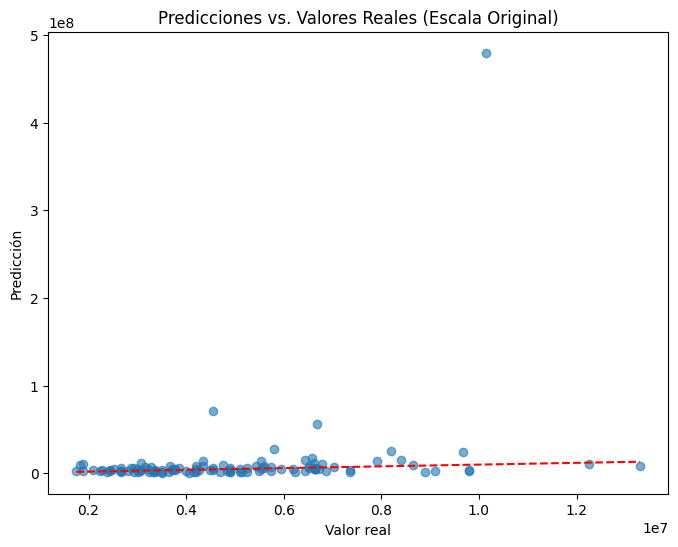

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Suponiendo que ya tienes:
# predictions_log: las predicciones del modelo en escala logarítmica
# y_test: los valores reales de la variable objetivo en escala logarítmica

# Ejemplo: si no lo has calculado aún, obten las predicciones en log:
predictions_log = model.predict(X_test)

# Métricas en escala logarítmica
mae_log = mean_absolute_error(y_test, predictions_log)
mse_log = mean_squared_error(y_test, predictions_log)
rmse_log = np.sqrt(mse_log)
r2_log = r2_score(y_test, predictions_log)

print("Métricas en escala logarítmica:")
print("MAE (log):", mae_log)
print("MSE (log):", mse_log)
print("RMSE (log):", rmse_log)
print("R2 (log):", r2_log)

# Convertir las predicciones y los valores reales a la escala original
predictions_original = np.exp(predictions_log)
y_true_original = np.exp(y_test)

# Métricas en la escala original
mae_original = mean_absolute_error(y_true_original, predictions_original)
mse_original = mean_squared_error(y_true_original, predictions_original)
rmse_original = np.sqrt(mse_original)
r2_original = r2_score(y_true_original, predictions_original)
mape = mean_absolute_percentage_error(y_true_original, predictions_original)

print("\nMétricas en escala original:")
print("MAE:", mae_original)
print("MSE:", mse_original)
print("RMSE:", rmse_original)
print("R2:", r2_original)
print("MAPE:", mape)

# Opcional: Graficar las predicciones vs. los valores reales
plt.figure(figsize=(8, 6))
plt.scatter(y_true_original, predictions_original, alpha=0.6)
plt.plot([y_true_original.min(), y_true_original.max()], [y_true_original.min(), y_true_original.max()], 'r--')
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Predicciones vs. Valores Reales (Escala Original)")
plt.show()


Métricas de éxito:

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Suponiendo que ya tienes:
# - y_true_original: los valores reales de precio (en escala original)
# - predictions_original: las predicciones del modelo (en escala original)
# - df: el DataFrame original, para calcular el precio promedio total

# Calcular el RMSE en la escala original:
mse_original = mean_squared_error(y_true_original, predictions_original)
rmse_original = np.sqrt(mse_original)

# Calcular el coeficiente de determinación (R²):
r2_original = r2_score(y_true_original, predictions_original)

# Calcular el precio promedio de las viviendas (usando el dataset completo)
precio_promedio = df['price'].mean()

# Definir el umbral para RMSE: 5% del precio promedio
umbral_rmse = 0.05 * precio_promedio

print("Precio promedio:", precio_promedio)
print("Umbral RMSE (5% del precio promedio):", umbral_rmse)
print("RMSE (modelo):", rmse_original)
print("R² (modelo):", r2_original)

# Verificar si se cumplen las condiciones:
if rmse_original < umbral_rmse and r2_original > 0.85:
    print("El modelo cumple con las métricas de éxito.")
else:
    print("El modelo NO cumple con las métricas de éxito.")


Precio promedio: 4766729.247706422
Umbral RMSE (5% del precio promedio): 238336.4623853211
RMSE (modelo): 45896387.12627522
R² (modelo): -415.74727001014463
El modelo NO cumple con las métricas de éxito.


## 4. Estrategias para mejorar nuestro modelo

### 4.1 Modelo Baseline (Regresión Lineal):

- Antes de seguir con arquitecturas complejas, es muy útil entrenar un modelo de regresión lineal con los datos preprocesados (con la variable objetivo en log). Esto te dará una referencia mínima para comparar el desempeño de la red neuronal.

- Si el modelo lineal también falla en capturar la relación, podríamos sospechar que el problema se encuentra en el preprocesamiento o en la calidad de las características.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Asumiendo que ya tienes X_train, X_test, y_train, y_test definidos (con y_train = price_log)

# Entrenar un modelo de regresión lineal
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predicciones en el conjunto de prueba (escala logarítmica)
predictions_log = lin_reg.predict(X_test)

# Calcular métricas en la escala logarítmica
mae_log = mean_absolute_error(y_test, predictions_log)
mse_log = mean_squared_error(y_test, predictions_log)
rmse_log = np.sqrt(mse_log)
r2_log = r2_score(y_test, predictions_log)

print("Métricas en escala logarítmica:")
print("MAE:", mae_log)
print("RMSE:", rmse_log)
print("R²:", r2_log)

# Convertir las predicciones a la escala original
predictions_original = np.exp(predictions_log)
y_true_original = np.exp(y_test)

# Métricas en la escala original
mae_original = mean_absolute_error(y_true_original, predictions_original)
mse_original = mean_squared_error(y_true_original, predictions_original)
rmse_original = np.sqrt(mse_original)
r2_original = r2_score(y_true_original, predictions_original)

precio_promedio = df['price'].mean()
umbral_rmse = 0.05 * precio_promedio

print("\nPrecio promedio:", precio_promedio)
print("Umbral RMSE (5%):", umbral_rmse)
print("RMSE (original):", rmse_original)
print("R² (original):", r2_original)


Métricas en escala logarítmica:
MAE: 0.20017523554808847
RMSE: 0.2488838838606374
R²: 0.6791983315505808

Precio promedio: 4766729.247706422
Umbral RMSE (5%): 238336.4623853211
RMSE (original): 1312852.617906591
R² (original): 0.6590052344043487


Conclusiones del Baseline

- Capacidad predictiva limitada:
El modelo lineal solo explica alrededor del 66% de la varianza de los precios en su escala original, lo que nos indica que la relación entre las características y el precio es compleja y probablemente no lineal.

- Error en la escala original:
Un RMSE de 1.31 millones es muy alto en comparación con el umbral deseado, lo que sugiere que un modelo más sofisticado es necesario para capturar las relaciones subyacentes y reducir el error.

### 4.2 Ajuste del Modelo de Red Neuronal:

- Dado que el modelo lineal sirve como baseline, podemos intentar mejorar con un modelo de red neuronal más complejo para capturar relaciones no lineales.

- Probaremos ajustar hiperparámetros (tasa de aprendizaje, número de capas y neuronas, regularización) y evaluar si podemos alcanzar un mejor desempeño.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Definir el modelo mejorado
model = Sequential()

# Capa de entrada con 128 neuronas y activación ReLU
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
# Dropout para reducir el sobreajuste
model.add(Dropout(0.2))

# Primera capa oculta con 64 neuronas
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Segunda capa oculta con 32 neuronas
model.add(Dense(32, activation='relu'))

# Capa de salida: 1 neurona, activación lineal para regresión
model.add(Dense(1, activation='linear'))

# Configuramos el optimizador con una tasa de aprendizaje moderada
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

# Mostrar resumen del modelo
model.summary()

# Usar EarlyStopping para detener el entrenamiento si no hay mejora en val_loss por 20 épocas
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs=300, 
                    batch_size=32, 
                    callbacks=[early_stop],
                    verbose=1)

# Evaluar el modelo en el conjunto de prueba
loss, mae = model.evaluate(X_test, y_test)
print("Test Loss (MSE):", loss)
print("Test MAE:", mae)

# Obtener predicciones en escala logarítmica
predictions_log = model.predict(X_test)

# Convertir predicciones y valores reales a escala original
predictions_original = np.exp(predictions_log)
y_true_original = np.exp(y_test)

# Calcular métricas en la escala original
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
mse_original = mean_squared_error(y_true_original, predictions_original)
rmse_original = np.sqrt(mse_original)
r2_original = r2_score(y_true_original, predictions_original)
mae_original = mean_absolute_error(y_true_original, predictions_original)

precio_promedio = df['price'].mean()
umbral_rmse = 0.05 * precio_promedio

print("\nPrecio promedio:", precio_promedio)
print("Umbral RMSE (5%):", umbral_rmse)
print("RMSE (original):", rmse_original)
print("R² (original):", r2_original)
print("MAE (original):", mae_original)


c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_49 (Dense)                │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,161 (47.50 KB)

 Trainable params: 12,161 (47.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 237.2920 - mae: 15.3919 - val_loss: 202.4422 - val_mae: 14.2231
Epoch 2/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 196.0408 - mae: 13.9865 - val_loss: 158.5249 - val_mae: 12.5745
Epoch 3/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 148.6215 - mae: 12.1400 - val_loss: 97.9001 - val_mae: 9.8156
Epoch 4/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 85.6818 - mae: 9.0724 - val_loss: 32.3595 - val_mae: 5.3420
Epoch 5/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 24.3618 - mae: 4.3512 - val_loss: 8.8057 - val_mae: 2.2682
Epoch 6/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11.2360 - mae: 2.6317 - val_loss: 9.6080 - val_mae: 2.3579
Epoch 7/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.5974 - mae: 2.4621 - val_loss: 4.1076 - val_mae: 1.5721
Epoch 8/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.0964 - mae: 2.0538 - val_loss: 3.2178 - val_mae: 1.4656
Epoch 9/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7

No obtenemos el resultado esperado.

### 4.3 Revisión de Ingeniería de Características:

- Nuevas variables: Considerar la creación de variables adicionales, como el ratio entre área y número de habitaciones, u otras combinaciones que puedan captar relaciones no lineales.

- Transformaciones adicionales: Verificar si otras variables con alta asimetría requieren transformaciones (además de price, area y bathrooms).

Vamos a crear algunas nuevas variables (features) que puedan ayudar a capturar relaciones importantes en los datos. Por ejemplo, podríamos generar:

- area_per_bedroom: Relación entre el área total y el número de habitaciones.

- area_per_bathroom: Relación entre el área total y el número de baños.

- area_per_story: Relación entre el área y el número de pisos.

- parking_per_bedroom: Número de plazas de estacionamiento por habitación.

- amenity_score: Un puntaje que sume los "yes" de las variables binarias que indican servicios o características (como mainroad, guestroom, basement, hotwaterheating, airconditioning, prefarea).

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Suponiendo que ya tienes el DataFrame original 'df'
df_preprocessed = df.copy()

# 1. Transformación de la variable objetivo: aplicamos logaritmo a 'price'
df_preprocessed['price_log'] = np.log(df_preprocessed['price'])

# 2. Feature Engineering en variables continuas
# Creamos variables derivadas que puedan capturar relaciones interesantes
df_preprocessed['area_per_bedroom'] = df_preprocessed['area'] / df_preprocessed['bedrooms']
df_preprocessed['area_per_bathroom'] = df_preprocessed['area'] / df_preprocessed['bathrooms']
df_preprocessed['area_per_story'] = df_preprocessed['area'] / df_preprocessed['stories']
df_preprocessed['parking_per_bedroom'] = df_preprocessed['parking'] / df_preprocessed['bedrooms']

# 3. Codificación de variables categóricas binarias
# Para las variables binarias, convertir 'yes' a 1 y 'no' a 0
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
df_preprocessed[binary_cols] = df_preprocessed[binary_cols].applymap(lambda x: 1 if x.lower() == 'yes' else 0)

# Creamos un puntaje de amenities que sume las variables binarias
df_preprocessed['amenity_score'] = df_preprocessed[binary_cols].sum(axis=1)

# 4. Codificación de 'furnishingstatus' mediante one-hot encoding
df_preprocessed = pd.get_dummies(df_preprocessed, columns=['furnishingstatus'], drop_first=True)

# 5. Selección de características y separación del target
# Aquí, mantenemos tanto las variables originales como las nuevas features.
# Eliminamos 'price' (ya que usamos su versión logarítmica para el target)
features = df_preprocessed.drop(columns=['price', 'price_log'])
target = df_preprocessed['price_log']

# 6. División en conjunto de entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# 7. Escalado de las características: ajustamos el scaler con los datos de entrenamiento
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Confirmamos las dimensiones
print("Tamaño de X_train:", X_train.shape)
print("Tamaño de X_test:", X_test.shape)


Tamaño de X_train: (436, 18)
Tamaño de X_test: (109, 18)


C:\Users\Alumno_AI\AppData\Local\Temp\ipykernel_17796\371949825.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_preprocessed[binary_cols] = df_preprocessed[binary_cols].applymap(lambda x: 1 if x.lower() == 'yes' else 0)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Definir el modelo mejorado
model = Sequential()

# Capa de entrada con 128 neuronas y activación ReLU
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
# Dropout para reducir el sobreajuste
model.add(Dropout(0.2))

# Primera capa oculta con 64 neuronas
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Segunda capa oculta con 32 neuronas
model.add(Dense(32, activation='relu'))

# Capa de salida: 1 neurona, activación lineal para regresión
model.add(Dense(1, activation='linear'))

# Configuramos el optimizador con una tasa de aprendizaje moderada
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

# Mostrar resumen del modelo
model.summary()

# Usar EarlyStopping para detener el entrenamiento si no hay mejora en val_loss por 20 épocas
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs=500, 
                    batch_size=32, 
                    callbacks=[early_stop],
                    verbose=1)

# Evaluar el modelo en el conjunto de prueba
loss, mae = model.evaluate(X_test, y_test)
print("Test Loss (MSE):", loss)
print("Test MAE:", mae)

# Obtener predicciones en escala logarítmica
predictions_log = model.predict(X_test)

# Convertir predicciones y valores reales a escala original
predictions_original = np.exp(predictions_log)
y_true_original = np.exp(y_test)

# Calcular métricas en la escala original
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
mse_original = mean_squared_error(y_true_original, predictions_original)
rmse_original = np.sqrt(mse_original)
r2_original = r2_score(y_true_original, predictions_original)
mae_original = mean_absolute_error(y_true_original, predictions_original)

precio_promedio = df['price'].mean()
umbral_rmse = 0.05 * precio_promedio

print("\nPrecio promedio:", precio_promedio)
print("Umbral RMSE (5%):", umbral_rmse)
print("RMSE (original):", rmse_original)
print("R² (original):", r2_original)
print("MAE (original):", mae_original)


c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_90 (Dense)                │ (None, 128)            │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,801 (50.00 KB)

 Trainable params: 12,801 (50.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 232.2576 - mae: 15.2317 - val_loss: 206.1909 - val_mae: 14.3522
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 197.4388 - mae: 14.0288 - val_loss: 159.5312 - val_mae: 12.6103
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 145.2348 - mae: 11.9560 - val_loss: 92.0715 - val_mae: 9.4988
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 73.4252 - mae: 8.2240 - val_loss: 23.9967 - val_mae: 4.4802
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 18.7091 - mae: 3.6139 - val_loss: 8.5385 - val_mae: 2.3620
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 15.4781 - mae: 2.8525 - val_loss: 6.7130 - val_mae: 2.1043
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.4602 - mae: 2.4754 - val_loss: 6.3284 - val_mae: 1.9302
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.6194 - mae: 2.3544 - val_loss: 5.0170 - val_mae: 1.7070
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8

Conclusión: obtenemos mucho peorers metricas aplicando lña feature engeniering tal y como lo estamos haciendo, probemos otra manera

### 4.4 Análisis Exploratorio de las Nuevas Variables:

Visualiza la distribución de cada nueva feature y su relación con el target (por ejemplo, con scatter plots o correlaciones).
Identifica si existen outliers o distribuciones muy sesgadas que puedan requerir transformaciones adicionales (por ejemplo, aplicar logaritmo a los ratios si tienen cola larga).

Estadísticas descriptivas de las nuevas variables:
       area_per_bedroom  area_per_bathroom  area_per_story  \
count        545.000000         545.000000      545.000000   
mean        1819.852599        4361.088379     3491.139602   
std          839.091825        2122.351542     2246.131370   
min          381.000000         870.000000      715.000000   
25%         1237.500000        3000.000000     1833.333333   
50%         1666.666667        3792.000000     2840.000000   
75%         2183.333333        5400.000000     4340.000000   
max         6600.000000       15600.000000    15600.000000   

       parking_per_bedroom  amenity_score  
count           545.000000     545.000000  
mean              0.236606       1.983486  
std               0.300656       1.195004  
min               0.000000       0.000000  
25%               0.000000       1.000000  
50%               0.000000       2.000000  
75%               0.500000       3.000000  
max               1.500000       5.000

C:\Users\Alumno_AI\AppData\Local\Temp\ipykernel_17796\3114382753.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_expl[binary_cols] = df_expl[binary_cols].applymap(lambda x: 1 if x.lower() == 'yes' else 0)


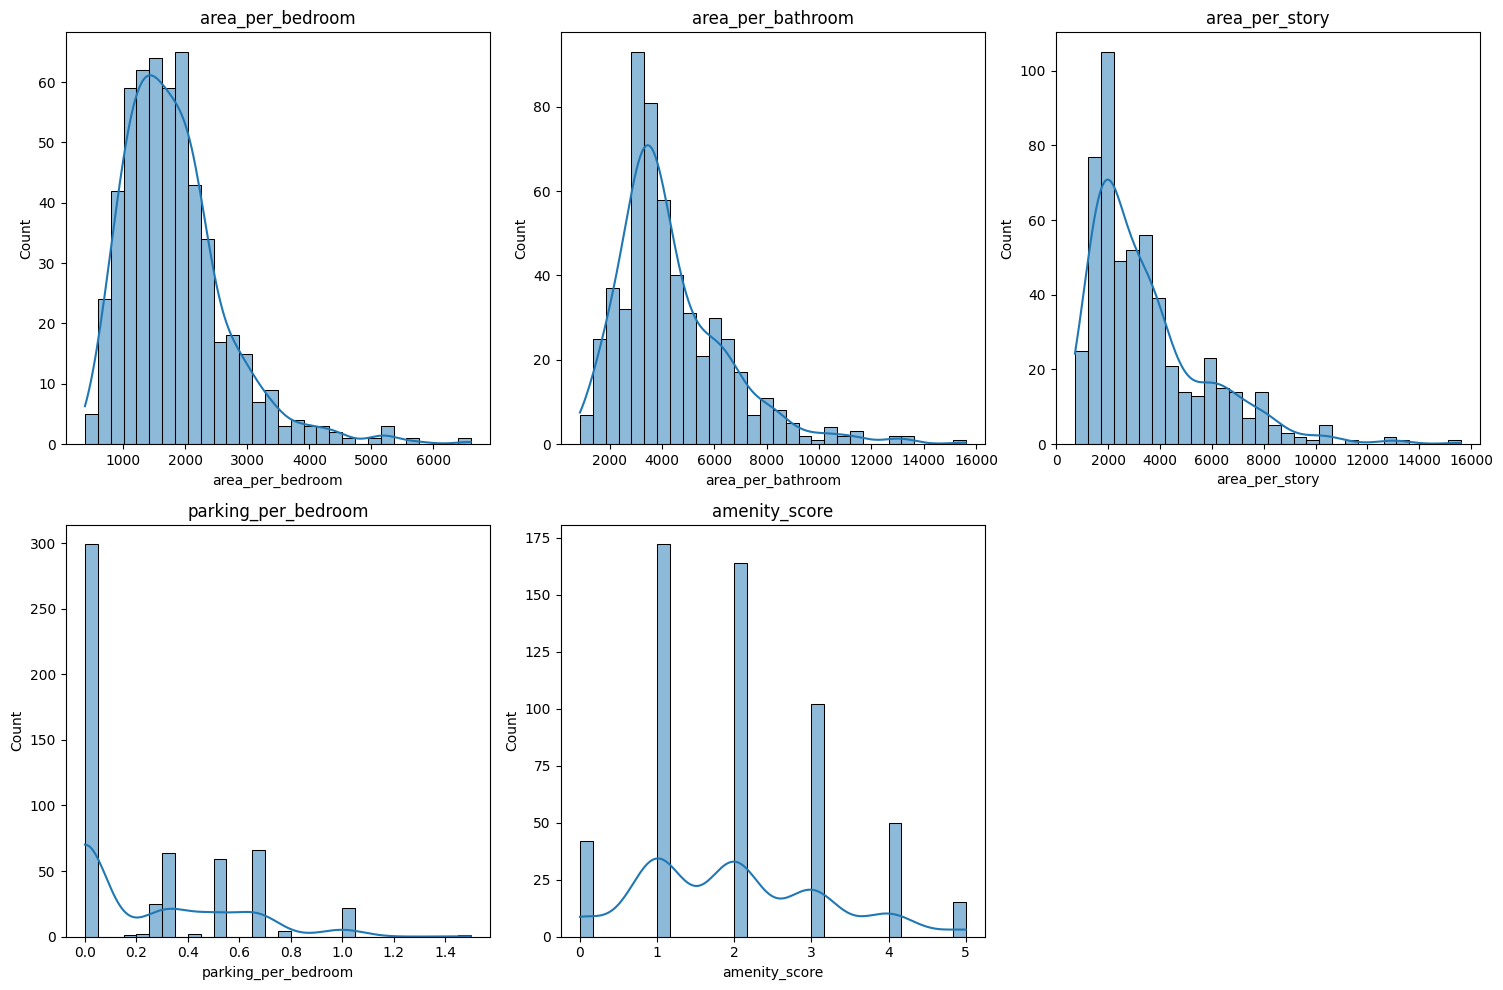

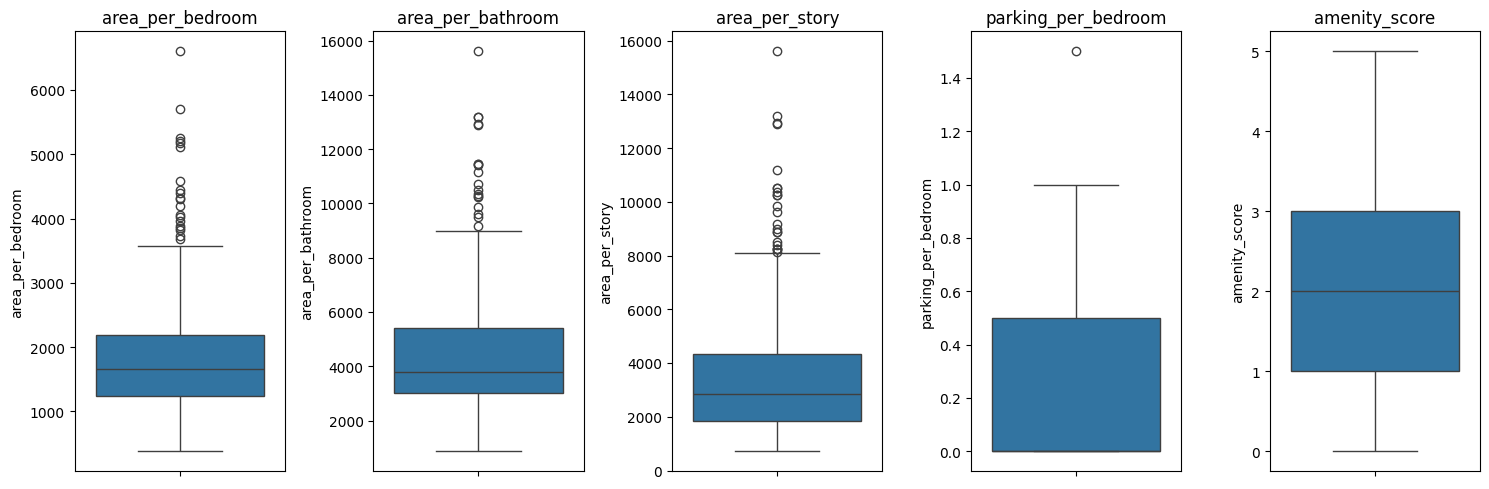

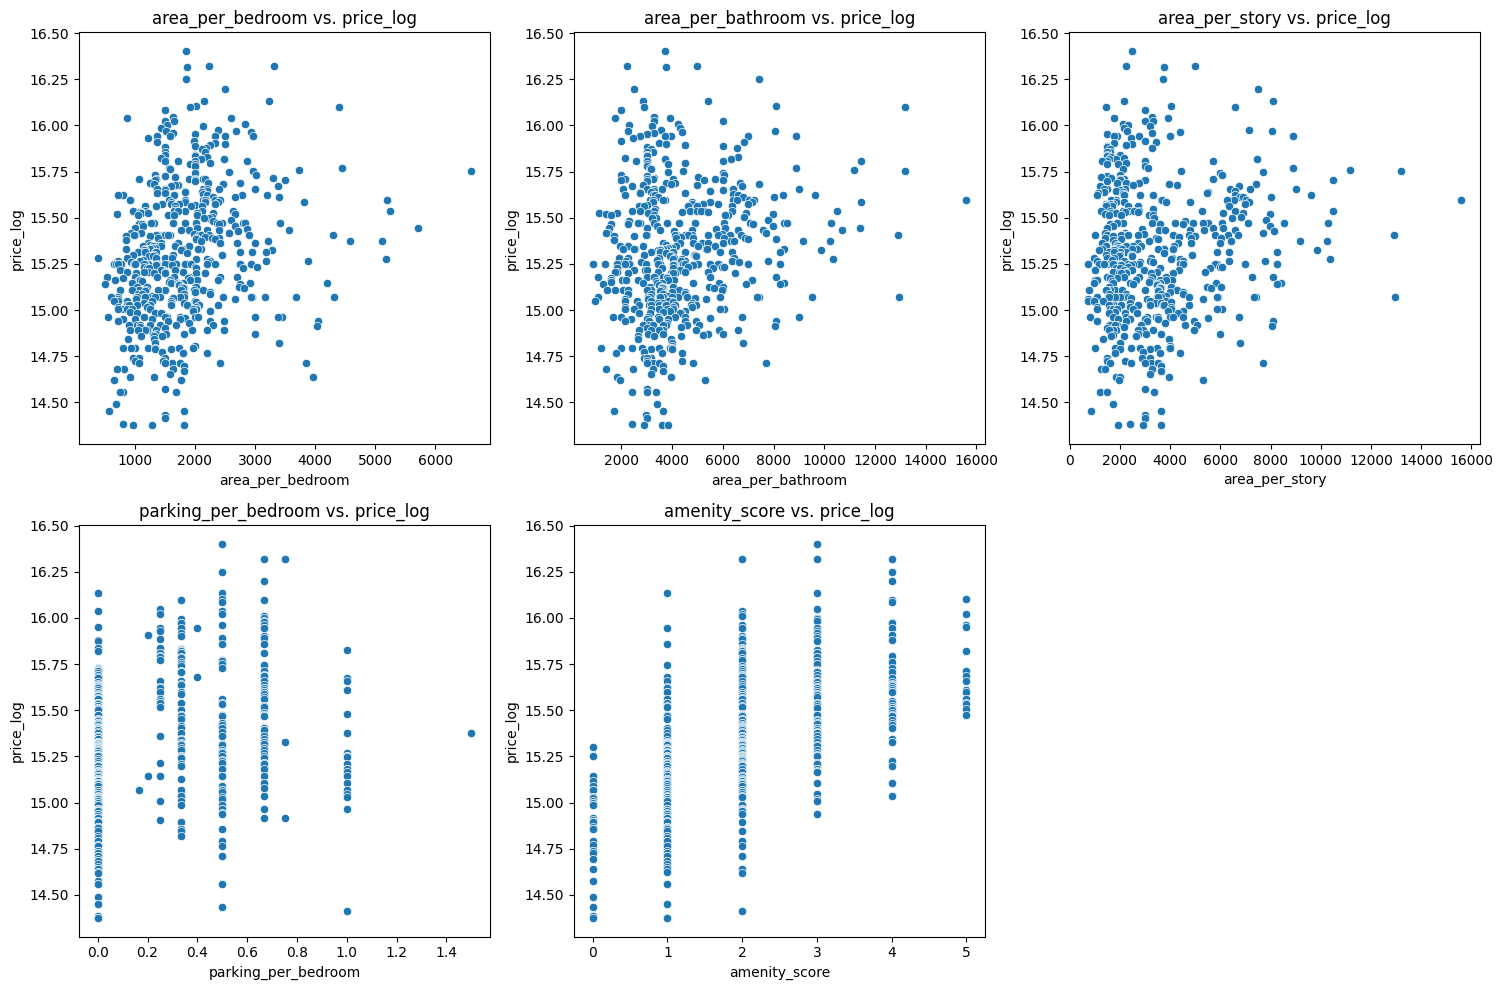

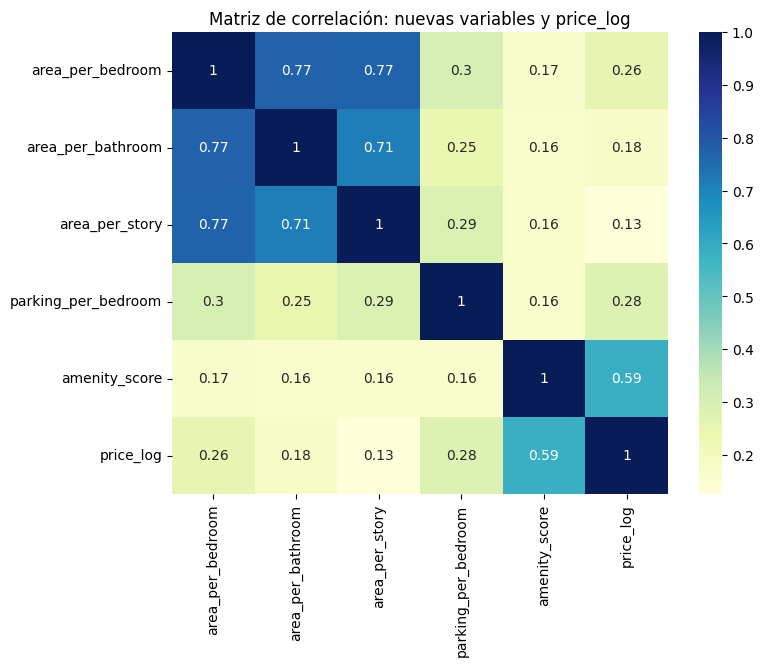

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Copia del DataFrame original para trabajar con las nuevas variables
df_expl = df.copy()

# 1. Creamos las nuevas variables (asegúrate de que las columnas necesarias existan)
df_expl['price_log'] = np.log(df_expl['price'])
df_expl['area_per_bedroom'] = df_expl['area'] / df_expl['bedrooms']
df_expl['area_per_bathroom'] = df_expl['area'] / df_expl['bathrooms']
df_expl['area_per_story'] = df_expl['area'] / df_expl['stories']
df_expl['parking_per_bedroom'] = df_expl['parking'] / df_expl['bedrooms']

# Para las variables binarias, las convertimos a 0/1
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
df_expl[binary_cols] = df_expl[binary_cols].applymap(lambda x: 1 if x.lower() == 'yes' else 0)

# Creamos el puntaje de amenities
df_expl['amenity_score'] = df_expl[binary_cols].sum(axis=1)

# Lista de nuevas variables a analizar
new_vars = ['area_per_bedroom', 'area_per_bathroom', 'area_per_story', 'parking_per_bedroom', 'amenity_score']

# 2. Estadísticas descriptivas de las nuevas variables
print("Estadísticas descriptivas de las nuevas variables:")
print(df_expl[new_vars].describe())

# 3. Histogramas para ver la distribución de cada nueva variable
plt.figure(figsize=(15,10))
for i, var in enumerate(new_vars):
    plt.subplot(2, 3, i+1)
    sns.histplot(df_expl[var], kde=True, bins=30)
    plt.title(var)
plt.tight_layout()
plt.show()

# 4. Boxplots para detectar outliers
plt.figure(figsize=(15, 5))
for i, var in enumerate(new_vars):
    plt.subplot(1, 5, i+1)
    sns.boxplot(y=df_expl[var])
    plt.title(var)
plt.tight_layout()
plt.show()

# 5. Scatter plots de cada nueva variable vs. price_log para ver la relación
plt.figure(figsize=(15,10))
for i, var in enumerate(new_vars):
    plt.subplot(2, 3, i+1)
    sns.scatterplot(x=df_expl[var], y=df_expl['price_log'])
    plt.title(f'{var} vs. price_log')
plt.tight_layout()
plt.show()

# 6. Matriz de correlación incluyendo las nuevas variables y la variable target
cols_corr = new_vars + ['price_log']
corr_matrix = df_expl[cols_corr].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu')
plt.title("Matriz de correlación: nuevas variables y price_log")
plt.show()


Conclusiones Finales

1. Revisar Outliers y Transformaciones:

- Considera aplicar np.log() o np.log1p() (log de x+1) a las variables area_per_bedroom, area_per_bathroom y area_per_story para reducir la asimetría.

- Alternativamente, podrías recortar (clipping) los valores más extremos si consideras que son atípicos poco representativos.

2. Selección de Variables (Feature Selection):

- Dado que area_per_bedroom, area_per_bathroom y area_per_story están muy correlacionadas, podrías quedarte con la que muestre mayor correlación con price_log (por ejemplo, area_per_bathroom) para reducir la redundancia.
- amenity_score muestra una correlación interesante (~0.59); convendría mantenerla en el modelo.

3. Análisis de Parking:

- parking_per_bedroom parece tener menor correlación. Podrías probar a excluirla o transformarla si consideras que su distribución afecta negativamente al entrenamiento.

4. Reentrenar y Evaluar:

- Tras decidir qué variables conservar y qué transformaciones aplicar, reentrena el modelo y compara las métricas (RMSE, R²).

- Aplica un proceso iterativo: prueba un cambio, evalúa resultados y conserva las mejoras.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Copia del DataFrame original
df_preprocessed = df.copy()

# 2. Transformar la variable objetivo: aplicamos logaritmo a 'price'
df_preprocessed['price_log'] = np.log(df_preprocessed['price'])

# 3. Codificación de variables binarias
# Convertimos 'yes' a 1 y 'no' a 0 para las variables relevantes
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
df_preprocessed[binary_cols] = df_preprocessed[binary_cols].applymap(lambda x: 1 if x.lower() == 'yes' else 0)

# 4. Crear 'amenity_score' como la suma de las variables binarias
df_preprocessed['amenity_score'] = df_preprocessed[binary_cols].sum(axis=1)

# 5. Seleccionar solo 'amenity_score' como característica y 'price_log' como target
features = df_preprocessed[['amenity_score']]
target = df_preprocessed['price_log']

# 6. División en conjunto de entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size=0.2, 
                                                    random_state=42)

# 7. Escalado de la única característica (aunque amenity_score es discreta, se escala para mantener consistencia)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_test:", X_test.shape)


Dimensiones de X_train: (436, 1)
Dimensiones de X_test: (109, 1)


C:\Users\Alumno_AI\AppData\Local\Temp\ipykernel_17796\2508094108.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_preprocessed[binary_cols] = df_preprocessed[binary_cols].applymap(lambda x: 1 if x.lower() == 'yes' else 0)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=300,
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=1)

loss, mae = model.evaluate(X_test, y_test)
print("Test Loss (MSE):", loss)
print("Test MAE:", mae)

# Predicciones en log
predictions_log = model.predict(X_test)

# Convertir a la escala original
predictions_original = np.exp(predictions_log)
y_true_original = np.exp(y_test)

# Métricas en la escala original
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
mse_original = mean_squared_error(y_true_original, predictions_original)
rmse_original = np.sqrt(mse_original)
r2_original = r2_score(y_true_original, predictions_original)
mae_original = mean_absolute_error(y_true_original, predictions_original)

print("\nRMSE (original):", rmse_original)
print("R² (original):", r2_original)
print("MAE (original):", mae_original)


Epoch 1/300


c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 233.2860 - mae: 15.2698 - val_loss: 231.0542 - val_mae: 15.1953
Epoch 2/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 232.3554 - mae: 15.2391 - val_loss: 230.0213 - val_mae: 15.1612
Epoch 3/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 230.0893 - mae: 15.1640 - val_loss: 228.9126 - val_mae: 15.1246
Epoch 4/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 230.2638 - mae: 15.1699 - val_loss: 227.7619 - val_mae: 15.0864
Epoch 5/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 228.7105 - mae: 15.1189 - val_loss: 226.5041 - val_mae: 15.0445
Epoch 6/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 227.8509 - mae: 15.0906 - val_loss: 225.0818 - val_mae: 14.9969
Epoch 7/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 226.2171 - mae: 15.0355 - val_loss: 223.4527 - val_mae: 14.9421
Epoch 8/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 225.1261 - mae: 14.9991 - val_loss: 221.6558 - val_mae: 14.8814
Epoch 9/300
11/11 ━━━━━━━━━

En vista de que nada parece funcionar, vamos ha hacer una prueba quitando los outliers:

In [ ]:
import pandas as pd
import numpy as np

# Copia del DataFrame original
df_clean = df.copy()

# Definir percentiles para filtrar outliers (ajusta estos valores según el análisis)
lower_bound = 0.01
upper_bound = 0.99

# Filtrar outliers para 'price', 'area' y 'bathrooms'
for col in ['price', 'area', 'bathrooms']:
    lower_lim = df_clean[col].quantile(lower_bound)
    upper_lim = df_clean[col].quantile(upper_bound)
    df_clean = df_clean[(df_clean[col] >= lower_lim) & (df_clean[col] <= upper_lim)]

print("Tamaño del dataset original:", df.shape[0])
print("Tamaño del dataset sin outliers:", df_clean.shape[0])


Tamaño del dataset original: 545
Tamaño del dataset sin outliers: 521


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Copia del DataFrame original
df_preprocessed = df.copy()

# 2. Creación de la variable objetivo en logaritmo
df_preprocessed['price_log'] = np.log(df_preprocessed['price'])

# 3. Seleccionar solo las columnas de interés
# Variables numéricas: area, bathrooms, stories, parking, bedrooms
# Variables binarias: airconditioning, prefarea
# Primero, convertir las variables binarias a 0/1
binary_cols = ['airconditioning', 'prefarea']
df_preprocessed[binary_cols] = df_preprocessed[binary_cols].applymap(lambda x: 1 if x.lower() == 'yes' else 0)

# Seleccionar las features (asegúrate de que las columnas existan en el DataFrame original)
selected_features = ['area', 'bathrooms', 'stories', 'parking', 'bedrooms', 'airconditioning', 'prefarea']
features = df_preprocessed[selected_features]

# Definir el target
target = df_preprocessed['price_log']

# 4. División en conjunto de entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# 5. Escalado de las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_test:", X_test.shape)


Dimensiones de X_train: (436, 7)
Dimensiones de X_test: (109, 7)


C:\Users\Alumno_AI\AppData\Local\Temp\ipykernel_17796\1449905294.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_preprocessed[binary_cols] = df_preprocessed[binary_cols].applymap(lambda x: 1 if x.lower() == 'yes' else 0)


In [ ]:
display(features)

,area,bathrooms,stories,parking,bedrooms,airconditioning,prefarea
0,7420,2,3,2,4,1,1
1,8960,4,4,3,4,1,0
2,9960,2,2,2,3,0,1
3,7500,2,2,3,4,1,1
4,7420,1,2,2,4,1,0
...,...,...,...,...,...,...,...
540,3000,1,1,2,2,0,0
541,2400,1,1,0,3,0,0
542,3620,1,1,0,2,0,0
543,2910,1,1,0,3,0,0


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=300,
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=1)

loss, mae = model.evaluate(X_test, y_test)
print("Test Loss (MSE):", loss)
print("Test MAE:", mae)

# Predicciones en log
predictions_log = model.predict(X_test)

# Convertir a la escala original
predictions_original = np.exp(predictions_log)
y_true_original = np.exp(y_test)

# Métricas en la escala original
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
mse_original = mean_squared_error(y_true_original, predictions_original)
rmse_original = np.sqrt(mse_original)
r2_original = r2_score(y_true_original, predictions_original)
mae_original = mean_absolute_error(y_true_original, predictions_original)

print("\nRMSE (original):", rmse_original)
print("R² (original):", r2_original)
print("MAE (original):", mae_original)


Epoch 1/300


c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 231.1358 - mae: 15.1977 - val_loss: 228.9555 - val_mae: 15.1248
Epoch 2/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 227.4551 - mae: 15.0756 - val_loss: 225.7569 - val_mae: 15.0190
Epoch 3/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 225.3730 - mae: 15.0069 - val_loss: 222.4129 - val_mae: 14.9075
Epoch 4/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 222.7035 - mae: 14.9174 - val_loss: 218.7693 - val_mae: 14.7849
Epoch 5/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 218.3971 - mae: 14.7728 - val_loss: 214.8663 - val_mae: 14.6523
Epoch 6/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 212.5443 - mae: 14.5720 - val_loss: 210.6275 - val_mae: 14.5067
Epoch 7/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 209.8577 - mae: 14.4792 - val_loss: 206.0421 - val_mae: 14.3475
Epoch 8/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 204.3618 - mae: 14.2868 - val_loss: 201.1402 - val_mae: 14.1751
Epoch 9/300
11/11 ━━━━━━━━━

Lo descartamos, ya que hemos empeorado el rendimiento

## 5.Simplificamos al máximo

En vista de que no hemos conseguido buenas metricas, vamos a problar una solucion mucho mas sencilla

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Copia del DataFrame original
df_preprocessed = df.copy()

# 2. Transformar la variable objetivo: aplicamos logaritmo a 'price'
df_preprocessed['price_log'] = np.log(df_preprocessed['price'])

# 3. Codificación de variables binarias
# Convertimos 'yes' a 1 y 'no' a 0 para las variables relevantes
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
df_preprocessed[binary_cols] = df_preprocessed[binary_cols].applymap(lambda x: 1 if x.lower() == 'yes' else 0)

# 4. Crear 'amenity_score' como la suma de las variables binarias
df_preprocessed['amenity_score'] = df_preprocessed[binary_cols].sum(axis=1)

# 5. Seleccionar solo 'amenity_score' como característica y 'price_log' como target
features = df_preprocessed[['amenity_score']]
target = df_preprocessed['price_log']

# 6. División en conjunto de entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size=0.2, 
                                                    random_state=42)

# 7. Escalado de la única característica (aunque amenity_score es discreta, se escala para mantener consistencia)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_test:", X_test.shape)


Dimensiones de X_train: (436, 1)
Dimensiones de X_test: (109, 1)


C:\Users\Alumno_AI\AppData\Local\Temp\ipykernel_15128\2508094108.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_preprocessed[binary_cols] = df_preprocessed[binary_cols].applymap(lambda x: 1 if x.lower() == 'yes' else 0)


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Parámetro para la tasa de aprendizaje
learning_rate = 0.001  # Puedes modificar este valor según tus experimentos

# Definir el modelo de red neuronal simple
model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Crear el optimizador usando la tasa de aprendizaje parametrizada
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compilar el modelo
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

# Mostrar resumen del modelo
model.summary()

# Configurar EarlyStopping para detener el entrenamiento si no hay mejora en la validación
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs=200, 
                    batch_size=32, 
                    callbacks=[early_stop],
                    verbose=1)


c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99 (396.00 B)

 Trainable params: 99 (396.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 232.9987 - mae: 15.2593 - val_loss: 230.2425 - val_mae: 15.1676
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 230.8171 - mae: 15.1879 - val_loss: 228.0907 - val_mae: 15.0960
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 228.1664 - mae: 15.0999 - val_loss: 225.7231 - val_mae: 15.0167
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 227.1841 - mae: 15.0661 - val_loss: 223.1184 - val_mae: 14.9289
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 223.0414 - mae: 14.9280 - val_loss: 220.2208 - val_mae: 14.8306
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 221.3352 - mae: 14.8701 - val_loss: 217.0611 - val_mae: 14.7226
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 218.4011 - mae: 14.7700 - val_loss: 213.5594 - val_mae: 14.6018
Epoch 8/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 215.1047 - mae: 14.6569 - val_loss: 209.6880 - val_mae: 14.4668
Epoch 9/200
11/

In [5]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Realizar predicciones en el conjunto de prueba
preds = model.predict(X_test)

# Calcular métricas
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, preds)
mae = mean_absolute_error(y_test, preds)

print("RMSE:", rmse)
print("R²:", r2)
print("MAE:", mae)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
RMSE: 0.3614228213836377
R²: 0.32349001460040905
MAE: 0.29465378570131184


In [7]:
# Convertir las predicciones a la escala original
predictions_original = np.exp(preds)
y_true_original = np.exp(y_test)

# Métricas en la escala original
mae_original = mean_absolute_error(y_true_original, predictions_original)
mse_original = mean_squared_error(y_true_original, predictions_original)
rmse_original = np.sqrt(mse_original)
r2_original = r2_score(y_true_original, predictions_original)

precio_promedio = df['price'].mean()
umbral_rmse = 0.05 * precio_promedio

rmse_test_percent = (rmse_original / np.mean(y_true_original)) * 100

print("\nPrecio promedio:", precio_promedio)
print("Umbral RMSE (5%):", umbral_rmse)
print("RMSE (original):", rmse_original)
print("R² (original):", r2_original)
print(f"RMSE (%): {rmse_test_percent:.2f}%")


Precio promedio: 4766729.247706422
Umbral RMSE (5%): 238336.4623853211
RMSE (original): 1953808.8385074104
R² (original): 0.24476883466424837
RMSE (%): 39.02%
